# Introduction

My school began using MAPS testing (https://www.nwea.org/map-growth/) four years ago in 2019 to test and track student growth.  To date, no real analysis has been done on any trends or student growth patterns.  I wanted to look at this data and see if there was anything that I could discover.

I was given permission from my administration to download the data from each testing session from the MAPS site.  Each testing session came with two files: one with testing data and one with student data.  I merged the assessment data with student data and then deleted the student names (and original data) to maintain anonymity. 

A couple of things to note:
1. Students are tested during 9th, 10th, and 11th grade.  They are not tested during 12th grade.
2. We took the science test only during the first year of testing, so this data was deleted.
3. MAPS has changed the testing names, norms, and goals during this timeframe which may impact findings.  I combined the data together where it matched and/or made sense.
4. During the first two years the spring testing was not done.
5. The StudentID numbers are unique to the MAPS site and are not useful identifiers elsewhere.

# Exploration and Data Cleaning

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from scipy.stats import linregress

## Cleaning Steps

**A summary of the cleaning steps taken:**
1. Combined the start date and start time columes to create a new datetime category.
2. Deleted the science testing data as there was only one years worth of data.
3. Added season and year columns to more easily sort which season and/or year the testing session happened in.
4. Added a class of column to more easily track class trends.
5. Removed the L in front of the lexile scores so that values could be converted to integers.
6. Removed the Goal standard error and range columns as they were not useful to my analysis.

In [3]:
#combine start date and time to create a datetime category
alldata = pd.read_csv('alldata.csv')
alldata['TestStartDateTime']= alldata['TestStartDate'] + ' ' + alldata['TestStartTime']
alldata['TestStartDateTime']=pd.to_datetime(alldata['TestStartDateTime'])

#deleting science tests (only 1 years worth of data)
alldata=alldata[alldata['Subject']!='Science']

#Add season(fall, winter, spring) and year columns
alldata[['Season', 'Year']]=alldata['TermName'].str.split(' ', expand=True)

#Add Class of column
def get_class(row):
    year = int(row['Year'].split('-')[0])
    grade = row['Grade']
    if grade == 9:
        return int(year + 4)
    elif grade == 10:
        return int(year + 3)
    elif grade == 11:
        return int(year + 2)
    else:
        return 'unknown'
alldata['ClassOf'] = alldata.apply(get_class, axis=1)

#Remove the L from the Lexile scores and change type to int
alldata[['LexileScore','LexileMin', 'LexileMax']] = alldata[['LexileScore','LexileMin', 'LexileMax']].astype(str).apply(lambda x: x.str.split('L').str[0])
alldata[['LexileScore','LexileMin', 'LexileMax']] = alldata[['LexileScore','LexileMin', 'LexileMax']].apply(pd.to_numeric, errors='coerce')

#Remove Goal Standard Error and Range columns
alldata = alldata.drop(['Goal1StdErr', 'Goal1Range', 'Goal2StdErr', 'Goal2Range', 'Goal3StdErr', 'Goal3Range', 'Goal4StdErr', 'Goal4Range', 'Goal5StdErr', 'Goal5Range'], axis=1)

alldata.to_csv('new_alldata.csv')
new_alldata = pd.read_csv('new_alldata.csv')
new_alldata = new_alldata.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)
print('Cleaned data')
new_alldata.head()

Cleaned data


,TermName,StudentID,StudentDateOfBirth,StudentGender,Grade,Subject,Course,TestName,TestID,TestStartDate,TestStartTime,TestDurationMinutes,TestRITScore,TestStandardError,TestPercentile,AchievementQuintile,PercentCorrect,RapidGuessingPercentage,LexileScore,LexileMin,LexileMax,Goal1Name,Goal1RitScore,Goal1Adjective,Goal2Name,Goal2RitScore,Goal2Adjective,Goal3Name,Goal3RitScore,Goal3Adjective,Goal4Name,Goal4RitScore,Goal4Adjective,Goal5Name,Goal5RitScore,Goal5Adjective,TestStartDateTime,Year,ClassOf,Season
0,Fall 2019-2020,108812,3/19/2005,M,9,Language Arts,Language Usage,Growth: Language 2-12 CCSS 2010 V2,597613978,10/8/2019,10:58:08,50,224,3.0,68.0,HiAvg,51,0.0,NaN,NaN,NaN,"Writing: Write, Revise Texts for Purpose and A...",224,HiAvg,"Language: Understand, Edit for Grammar, Usage",227,HiAvg,"Language: Understand, Edit for Mechanics",222,HiAvg,NaN,NaN,NaN,NaN,NaN,NaN,2019-10-08 10:58:08,2019-2020,2023,Fall
1,Fall 2019-2020,108812,3/19/2005,M,9,Mathematics,Math K-12,Growth: Math 6+ CCSS 2010 V2,597016670,10/7/2019,12:58:42,83,237,3.0,70.0,HiAvg,50,0.0,NaN,NaN,NaN,Operations and Algebraic Thinking,244,HiAvg,The Real and Complex Number Systems,238,HiAvg,Geometry,241,HiAvg,Statistics and Probability,227.0,Avg,NaN,NaN,NaN,2019-10-07 12:58:42,2019-2020,2023,Fall
2,Fall 2019-2020,108812,3/19/2005,M,9,Language Arts,Reading,Growth: Reading 6+ CCSS 2010 V3,599173002,10/1/2019,10:52:49,74,233,3.4,77.0,HiAvg,56,0.0,1330.0,1230.0,1380.0,Literary Text: Key Ideas and Details,235,HiAvg,"Literary Text: Language, Craft, and Structure",230,HiAvg,Informational Text: Key Ideas and Details,236,HiAvg,"Informational Text: Language, Craft, and Struc...",230.0,HiAvg,Vocabulary: Acquisition and Use,232.0,HiAvg,2019-10-01 10:52:49,2019-2020,2023,Fall
3,Fall 2019-2020,114804,9/18/2003,F,11,Language Arts,Language Usage,Growth: Language 2-12 CCSS 2010 V2,597815418,10/7/2019,10:53:18,56,248,3.0,97.0,High,64,0.0,NaN,NaN,NaN,"Writing: Write, Revise Texts for Purpose and A...",257,High,"Language: Understand, Edit for Grammar, Usage",240,High,"Language: Understand, Edit for Mechanics",248,High,NaN,NaN,NaN,NaN,NaN,NaN,2019-10-07 10:53:18,2019-2020,2021,Fall
4,Fall 2019-2020,114804,9/18/2003,F,11,Mathematics,Math K-12,Growth: Math 6+ CCSS 2010 V2,596639585,10/17/2019,12:39:36,65,273,3.1,98.0,High,50,0.0,NaN,NaN,NaN,Operations and Algebraic Thinking,267,High,The Real and Complex Number Systems,282,High,Geometry,275,High,Statistics and Probability,267.0,High,NaN,NaN,NaN,2019-10-17 12:39:36,2019-2020,2021,Fall


In [4]:
new_alldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3008 entries, 0 to 3007
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TermName                 3008 non-null   object 
 1   StudentID                3008 non-null   int64  
 2   StudentDateOfBirth       3008 non-null   object 
 3   StudentGender            3008 non-null   object 
 4   Grade                    3008 non-null   int64  
 5   Subject                  3008 non-null   object 
 6   Course                   3008 non-null   object 
 7   TestName                 3008 non-null   object 
 8   TestID                   3008 non-null   int64  
 9   TestStartDate            3008 non-null   object 
 10  TestStartTime            3008 non-null   object 
 11  TestDurationMinutes      3008 non-null   int64  
 12  TestRITScore             3008 non-null   int64  
 13  TestStandardError        3008 non-null   float64
 14  TestPercentile          

Separate all the MAPS data into smaller dataframes that only have data about each type of test: Math, Reading, and Language.

In [5]:
math = new_alldata[new_alldata['Subject']=='Mathematics']
lang = new_alldata[new_alldata['Course']=='Language Usage']
read = new_alldata[new_alldata['Course']=='Reading']

In [6]:
print('Math Data')
math.head()

Math Data


,TermName,StudentID,StudentDateOfBirth,StudentGender,Grade,Subject,Course,TestName,TestID,TestStartDate,TestStartTime,TestDurationMinutes,TestRITScore,TestStandardError,TestPercentile,AchievementQuintile,PercentCorrect,RapidGuessingPercentage,LexileScore,LexileMin,LexileMax,Goal1Name,Goal1RitScore,Goal1Adjective,Goal2Name,Goal2RitScore,Goal2Adjective,Goal3Name,Goal3RitScore,Goal3Adjective,Goal4Name,Goal4RitScore,Goal4Adjective,Goal5Name,Goal5RitScore,Goal5Adjective,TestStartDateTime,Year,ClassOf,Season
1,Fall 2019-2020,108812,3/19/2005,M,9,Mathematics,Math K-12,Growth: Math 6+ CCSS 2010 V2,597016670,10/7/2019,12:58:42,83,237,3.0,70.0,HiAvg,50,0.0,NaN,NaN,NaN,Operations and Algebraic Thinking,244,HiAvg,The Real and Complex Number Systems,238,HiAvg,Geometry,241,HiAvg,Statistics and Probability,227.0,Avg,NaN,NaN,NaN,2019-10-07 12:58:42,2019-2020,2023,Fall
4,Fall 2019-2020,114804,9/18/2003,F,11,Mathematics,Math K-12,Growth: Math 6+ CCSS 2010 V2,596639585,10/17/2019,12:39:36,65,273,3.1,98.0,High,50,0.0,NaN,NaN,NaN,Operations and Algebraic Thinking,267,High,The Real and Complex Number Systems,282,High,Geometry,275,High,Statistics and Probability,267.0,High,NaN,NaN,NaN,2019-10-17 12:39:36,2019-2020,2021,Fall
7,Fall 2019-2020,1200563,9/6/2003,F,10,Mathematics,Math K-12,Growth: Math 6+ CCSS 2010 V2,596639554,10/2/2019,9:03:13,87,259,3.2,93.0,High,46,0.0,NaN,NaN,NaN,Operations and Algebraic Thinking,252,High,The Real and Complex Number Systems,264,High,Geometry,270,High,Statistics and Probability,250.0,High,NaN,NaN,NaN,2019-10-02 09:03:13,2019-2020,2022,Fall
10,Fall 2019-2020,1205294,5/5/2005,M,9,Mathematics,Math K-12,Growth: Math 6+ CCSS 2010 V2,597613785,10/7/2019,13:00:44,64,221,3.0,39.0,LoAvg,46,0.0,NaN,NaN,NaN,Operations and Algebraic Thinking,222,Avg,The Real and Complex Number Systems,224,Avg,Geometry,216,LoAvg,Statistics and Probability,223.0,Avg,NaN,NaN,NaN,2019-10-07 13:00:44,2019-2020,2023,Fall
13,Fall 2019-2020,1205333,9/6/2002,F,11,Mathematics,Math K-12,Growth: Math 6+ CCSS 2010 V2,599172836,9/30/2019,13:17:04,50,229,3.0,45.0,Avg,55,0.0,NaN,NaN,NaN,Operations and Algebraic Thinking,244,HiAvg,The Real and Complex Number Systems,218,LoAvg,Geometry,229,Avg,Statistics and Probability,223.0,LoAvg,NaN,NaN,NaN,2019-09-30 13:17:04,2019-2020,2021,Fall


In [7]:
print('Language Data')
lang.head()

Language Data


,TermName,StudentID,StudentDateOfBirth,StudentGender,Grade,Subject,Course,TestName,TestID,TestStartDate,TestStartTime,TestDurationMinutes,TestRITScore,TestStandardError,TestPercentile,AchievementQuintile,PercentCorrect,RapidGuessingPercentage,LexileScore,LexileMin,LexileMax,Goal1Name,Goal1RitScore,Goal1Adjective,Goal2Name,Goal2RitScore,Goal2Adjective,Goal3Name,Goal3RitScore,Goal3Adjective,Goal4Name,Goal4RitScore,Goal4Adjective,Goal5Name,Goal5RitScore,Goal5Adjective,TestStartDateTime,Year,ClassOf,Season
0,Fall 2019-2020,108812,3/19/2005,M,9,Language Arts,Language Usage,Growth: Language 2-12 CCSS 2010 V2,597613978,10/8/2019,10:58:08,50,224,3.0,68.0,HiAvg,51,0.0000,NaN,NaN,NaN,"Writing: Write, Revise Texts for Purpose and A...",224,HiAvg,"Language: Understand, Edit for Grammar, Usage",227,HiAvg,"Language: Understand, Edit for Mechanics",222,HiAvg,NaN,NaN,NaN,NaN,NaN,NaN,2019-10-08 10:58:08,2019-2020,2023,Fall
3,Fall 2019-2020,114804,9/18/2003,F,11,Language Arts,Language Usage,Growth: Language 2-12 CCSS 2010 V2,597815418,10/7/2019,10:53:18,56,248,3.0,97.0,High,64,0.0000,NaN,NaN,NaN,"Writing: Write, Revise Texts for Purpose and A...",257,High,"Language: Understand, Edit for Grammar, Usage",240,High,"Language: Understand, Edit for Mechanics",248,High,NaN,NaN,NaN,NaN,NaN,NaN,2019-10-07 10:53:18,2019-2020,2021,Fall
6,Fall 2019-2020,1200563,9/6/2003,F,10,Language Arts,Language Usage,Growth: Language 2-12 CCSS 2010 V2,597815684,10/7/2019,13:56:58,43,245,2.9,96.0,High,57,0.0000,NaN,NaN,NaN,"Writing: Write, Revise Texts for Purpose and A...",248,High,"Language: Understand, Edit for Grammar, Usage",239,High,"Language: Understand, Edit for Mechanics",247,High,NaN,NaN,NaN,NaN,NaN,NaN,2019-10-07 13:56:58,2019-2020,2022,Fall
9,Fall 2019-2020,1205294,5/5/2005,M,9,Language Arts,Language Usage,Growth: Language 2-12 CCSS 2010 V2,597815679,10/7/2019,14:08:33,49,220,2.9,58.0,Avg,56,3.8462,NaN,NaN,NaN,"Writing: Write, Revise Texts for Purpose and A...",222,HiAvg,"Language: Understand, Edit for Grammar, Usage",220,Avg,"Language: Understand, Edit for Mechanics",219,Avg,NaN,NaN,NaN,NaN,NaN,NaN,2019-10-07 14:08:33,2019-2020,2023,Fall
12,Fall 2019-2020,1205333,9/6/2002,F,11,Language Arts,Language Usage,Growth: Language 2-12 CCSS 2010 V2,597815826,10/7/2019,10:52:35,46,231,2.9,76.0,HiAvg,54,0.0000,NaN,NaN,NaN,"Writing: Write, Revise Texts for Purpose and A...",243,High,"Language: Understand, Edit for Grammar, Usage",222,Avg,"Language: Understand, Edit for Mechanics",228,HiAvg,NaN,NaN,NaN,NaN,NaN,NaN,2019-10-07 10:52:35,2019-2020,2021,Fall


In [8]:
print('Reading Data')
read.head()

Reading Data


,TermName,StudentID,StudentDateOfBirth,StudentGender,Grade,Subject,Course,TestName,TestID,TestStartDate,TestStartTime,TestDurationMinutes,TestRITScore,TestStandardError,TestPercentile,AchievementQuintile,PercentCorrect,RapidGuessingPercentage,LexileScore,LexileMin,LexileMax,Goal1Name,Goal1RitScore,Goal1Adjective,Goal2Name,Goal2RitScore,Goal2Adjective,Goal3Name,Goal3RitScore,Goal3Adjective,Goal4Name,Goal4RitScore,Goal4Adjective,Goal5Name,Goal5RitScore,Goal5Adjective,TestStartDateTime,Year,ClassOf,Season
2,Fall 2019-2020,108812,3/19/2005,M,9,Language Arts,Reading,Growth: Reading 6+ CCSS 2010 V3,599173002,10/1/2019,10:52:49,74,233,3.4,77.0,HiAvg,56,0.0,1330.0,1230.0,1380.0,Literary Text: Key Ideas and Details,235,HiAvg,"Literary Text: Language, Craft, and Structure",230,HiAvg,Informational Text: Key Ideas and Details,236,HiAvg,"Informational Text: Language, Craft, and Struc...",230.0,HiAvg,Vocabulary: Acquisition and Use,232.0,HiAvg,2019-10-01 10:52:49,2019-2020,2023,Fall
5,Fall 2019-2020,114804,9/18/2003,F,11,Language Arts,Reading,Growth: Reading 6+ CCSS 2010 V3,599417166,9/30/2019,10:55:30,70,250,3.5,93.0,High,63,0.0,1675.0,1575.0,1725.0,Literary Text: Key Ideas and Details,251,High,"Literary Text: Language, Craft, and Structure",244,High,Informational Text: Key Ideas and Details,248,High,"Informational Text: Language, Craft, and Struc...",244.0,High,Vocabulary: Acquisition and Use,262.0,High,2019-09-30 10:55:30,2019-2020,2021,Fall
8,Fall 2019-2020,1200563,9/6/2003,F,10,Language Arts,Reading,Growth: Reading 6+ CCSS 2010 V3,599416751,9/30/2019,14:06:16,59,246,3.5,91.0,High,61,0.0,1595.0,1495.0,1645.0,Literary Text: Key Ideas and Details,247,High,"Literary Text: Language, Craft, and Structure",246,High,Informational Text: Key Ideas and Details,246,High,"Informational Text: Language, Craft, and Struc...",254.0,High,Vocabulary: Acquisition and Use,238.0,HiAvg,2019-09-30 14:06:16,2019-2020,2022,Fall
11,Fall 2019-2020,1205294,5/5/2005,M,9,Language Arts,Reading,Growth: Reading 6+ CCSS 2010 V3,596763340,9/30/2019,15:01:51,43,219,3.2,50.0,Avg,48,5.0,1050.0,950.0,1100.0,Literary Text: Key Ideas and Details,214,LoAvg,"Literary Text: Language, Craft, and Structure",219,Avg,Informational Text: Key Ideas and Details,222,Avg,"Informational Text: Language, Craft, and Struc...",220.0,Avg,Vocabulary: Acquisition and Use,220.0,Avg,2019-09-30 15:01:51,2019-2020,2023,Fall
14,Fall 2019-2020,1205333,9/6/2002,F,11,Language Arts,Reading,Growth: Reading 6+ CCSS 2010 V3,596903984,9/30/2019,10:55:10,79,238,3.4,79.0,HiAvg,55,0.0,1435.0,1335.0,1485.0,Literary Text: Key Ideas and Details,243,High,"Literary Text: Language, Craft, and Structure",233,HiAvg,Informational Text: Key Ideas and Details,233,HiAvg,"Informational Text: Language, Craft, and Struc...",237.0,HiAvg,Vocabulary: Acquisition and Use,243.0,High,2019-09-30 10:55:10,2019-2020,2021,Fall


## Norms
The MAPS test is scored in terms of the Rasch Unit or RIT Score.  More info here: https://teach.mapnwea.org/impl/maphelp/Content/AboutMAP/WhatRITMeans.htm.

The MAPS tests have norms for each test, grade level, and season the testing session is completed in.  I collected the norms data from https://masterygenius.com/blog/nwea-map-scores/ and I created an excel spreadsheet that gave the high and low values for each grade level and each test.

In [9]:
norms=pd.read_csv('ScoreNorms.csv')
print('Norms Data')
norms

Norms Data


,Test,Grade,FallLow,FallHigh,WinterLow,WinterHigh,SpringLow,SpringHigh
0,Mathematics,9,221,242,224,245,225,246
1,Mathematics,10,224,245,226,248,227,249
2,Mathematics,11,227,248,228,250,229,251
3,Reading,9,214,234,216,235,216,236
4,Reading,10,217,236,218,237,218,238
5,Reading,11,219,237,220,239,219,239
6,Language,9,213,229,214,230,215,231
7,Language,10,215,231,216,232,217,233
8,Language,11,217,232,218,233,218,234


Visual of the norms for each test type and season.  These are based off of the 9th grade low and 11th grade high for each test type.

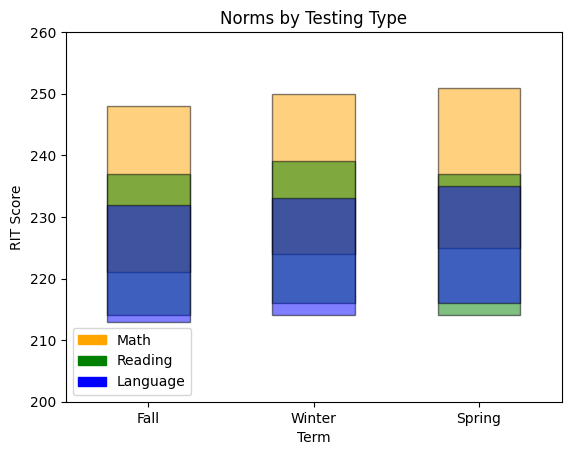

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)

mathfall = patches.Rectangle((0.5, 221), 1, 27, edgecolor='black', facecolor = 'orange', alpha =0.5)
mathwinter = patches.Rectangle((2.5, 224), 1, 26, edgecolor='black', facecolor = 'orange', alpha =0.5)
mathspring = patches.Rectangle((4.5, 225), 1, 26, edgecolor='black', facecolor = 'orange', alpha =0.5)
readfall = patches.Rectangle((0.5, 214), 1, 23, edgecolor = 'black', facecolor = 'green', alpha =0.5)
readwinter = patches.Rectangle((2.5, 216), 1, 23, edgecolor = 'black', facecolor = 'green', alpha =0.5)
readspring = patches.Rectangle((4.5, 214), 1, 23, edgecolor = 'black', facecolor = 'green', alpha =0.5)
langfall = patches.Rectangle((0.5, 213), 1, 19, edgecolor= 'black', facecolor= 'blue', alpha =0.5)
langwinter = patches.Rectangle((2.5, 214), 1, 19, edgecolor= 'black', facecolor= 'blue', alpha =0.5)
langspring = patches.Rectangle((4.5, 216), 1, 19, edgecolor= 'black', facecolor= 'blue', alpha =0.5)

ax.add_patch(mathfall)
ax.add_patch(mathwinter)
ax.add_patch(mathspring)
ax.add_patch(readfall)
ax.add_patch(readwinter)
ax.add_patch(readspring)
ax.add_patch(langfall)
ax.add_patch(langwinter)
ax.add_patch(langspring)

plt.xlim([0, 6])
plt.ylim([200, 260])

# Add legend
orange_patch = patches.Patch(color='orange', label='Math')
green_patch = patches.Patch(color='green', label='Reading')
blue_patch = patches.Patch(color='blue', label='Language')
plt.legend(handles=[orange_patch, green_patch, blue_patch])

# Change x-axis tick labels
plt.xticks([1, 3, 5], ['Fall', 'Winter', 'Spring'])

plt.title('Norms by Testing Type')
plt.ylabel('RIT Score')
plt.xlabel('Term')
plt.show()

## Basic Exploration

In [11]:
SELECT COUNT(DISTINCT StudentID)
FROM new_alldata.csv;

,count(DISTINCT StudentID)
0,245


In [12]:
--Avg /Min/Max RIT per test type
SELECT TestName, ROUND(AVG(TestRITScore), 2) AS "AVG RIT", 
		MIN(TestRITScore) AS "Min RIT",
		MAX(TestRITScore) AS "Max RIT",
		COUNT(*) AS Number
FROM 'new_alldata.csv'
GROUP BY TestName;

,TestName,AVG RIT,Min RIT,Max RIT,Number
0,Growth: Language 2-12 CCSS 2010 V2,227.18,185,260,458
1,Growth: Math 6+ CCSS 2010 V2,241.43,184,282,1004
2,Growth: Reading 6+ CCSS 2010 V3,230.19,176,268,458
3,Growth: Language 2-12 OR 2019,229.36,185,270,545
4,Growth: Reading 6+ OR 2019,230.39,190,275,543


Comparing our school's average RIT score over all students and all testing sessions, it appears that our school fits into the average range of the norms.  The Min and Max RIT scores fall outside of the low and high ranges.

# Data Analysis & Visualization

## Correlation
Create a heat map to explore the correlation between variables.

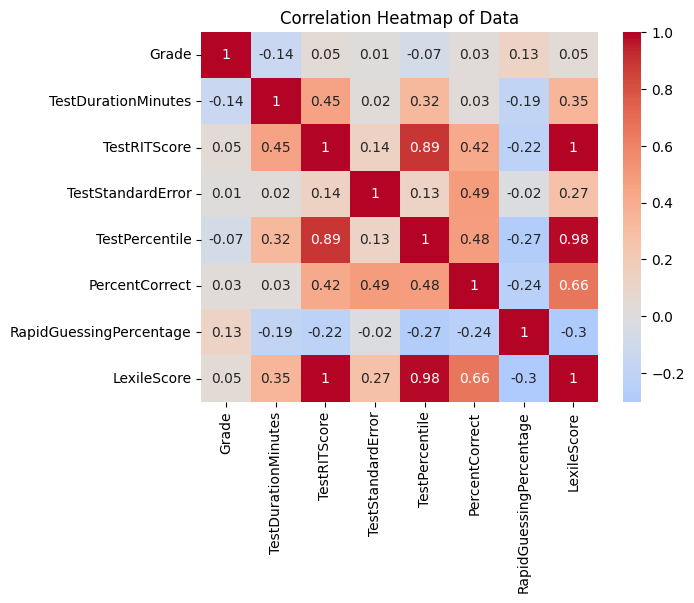

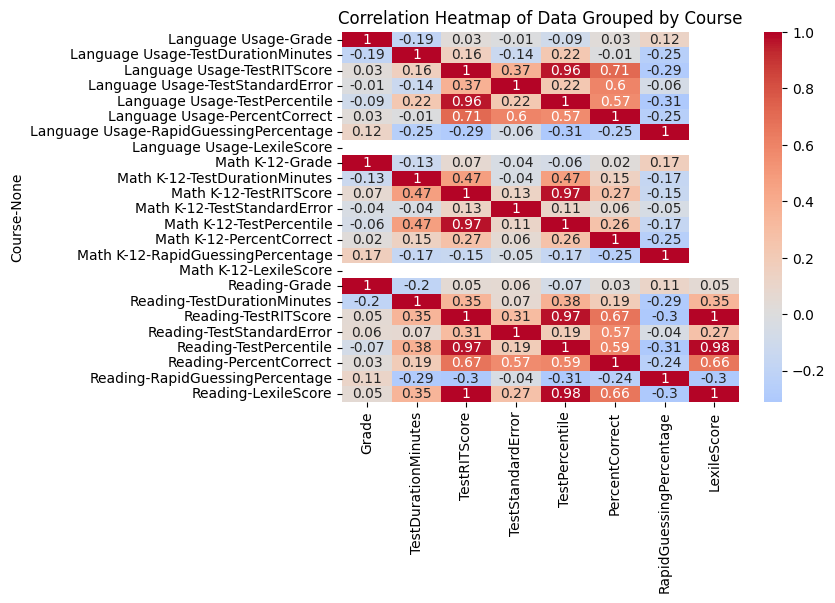

In [13]:
smalldata = new_alldata[['Grade', 'Course', 'TestDurationMinutes', 'TestRITScore', 'TestStandardError', 'TestPercentile', 'PercentCorrect', 'RapidGuessingPercentage', 'LexileScore']]

# Create a heatmap from smalldata
heatmap1 = sns.heatmap(smalldata.corr().round(2), annot=True, cmap="coolwarm", center=0)
heatmap1.set_title("Correlation Heatmap of Data")
plt.show()

# Group smalldata by Course
grouped_data = smalldata.groupby('Course').corr().round(2)

# Create a heatmap from grouped_data
heatmap2 = sns.heatmap(grouped_data, annot=True, cmap="coolwarm", center=0)
heatmap2.set_title("Correlation Heatmap of Data Grouped by Course")
plt.show()

Based on the analysis, there is a moderate correlation (0.45) between Test Duration and RIT Score overall. However, when examining the correlation separately for each test, it is found to be very weak for Language (0.16), weak for Reading (0.35), and moderate for Mathematics (0.47).

Furthermore, Test Percentile and Test Duration exhibit a moderate correlation (0.38). However, when considering each test individually, the correlation weakens for Language (0.22), becomes moderate for Mathematics (0.47), and stays the same for Reading (0.38).

In contrast, Test Percentile and RIT Score demonstrate a very strong overall correlation (0.89). Interestingly, when the data is segregated by test, the correlation values increase significantly for Language (0.96), Mathematics (0.97), and Reading (0.97).

Moreover, Percent Correct and RIT Score display a moderate correlation (0.42). However, when examining the separate tests, Language and Reading exhibit a strong correlation (0.71 and 0.67 respectively), while Mathematics shows a weak correlation (0.27).

Similarly, Percent Correct and Test Standard Error exhibit a moderate correlation (0.49). Language demonstrates a strong correlation (0.6), Reading displays a moderate correlation (0.57), but Mathematics exhibits a very weak correlation (0.06).

Additionally, Percent Correct and Test Percentile also demonstrate a moderate correlation (0.48). Language and Reading exhibit a moderate correlation as well (0.57 and 0.59 respectively), while Mathematics shows a weak correlation (0.26).

It is worth noting that only the Reading test includes a Lexile Score. The heat map reveals that the Lexile Score has a very strong correlation with Test Percentile (0.97) and a strong correlation with Percent Correct.

## Test Scores

In [14]:
--Average RIT scores per term per test
SELECT m.TermName, ROUND(AVG(m.TestRITScore),2) AS "Math AVG RIT",
	ROUND(AVG(r.TestRITScore),2) AS "Reading AVG RIT",
	ROUND(AVG(l.TestRITScore),2) AS "Lang AVG RIT"
FROM 'Math.csv' as m
INNER JOIN 'Reading.csv' as r
ON m.TermName = r.TermName
INNER JOIN 'Language.csv' as l
ON m.TermName = l.TermName
GROUP BY m.TermName;

,TermName,Math AVG RIT,Reading AVG RIT,Lang AVG RIT
0,Fall 2019-2020,241.14,230.80,227.23
1,Winter 2019-2020,241.84,229.50,226.99
2,Fall 2020-2021,239.55,229.09,227.57
3,Winter 2020-2021,242.08,231.43,226.91
4,Fall 2021-2022,241.34,229.18,230.09
5,Winter 2021-2022,242.86,230.55,229.99
6,Spring 2021-2022,243.37,230.22,228.93
7,Fall 2022-2023,240.18,230.32,228.07
8,Winter 2022-2023,240.88,231.41,229.40
9,Spring 2022-2023,241.80,230.55,229.69


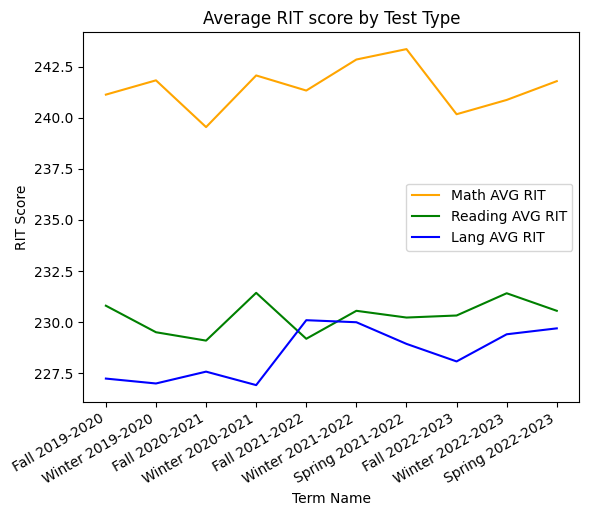

In [15]:
df5.plot(x='TermName', color={'Math AVG RIT': 'orange', 'Reading AVG RIT': 'green', 'Lang AVG RIT': 'blue'})
plt.title('Average RIT score by Test Type')
plt.xlabel('Term Name')
plt.ylabel('RIT Score')
plt.xticks(range(len(df5)), df5['TermName'], rotation=30, ha='right')

plt.show()

The math data shows that the average Math RIT scores increased after each testing session in the same year with a dip each Fall.

The reading data shows that the average Reading RIT scores has no discernable pattern.

The language data shows that the average Language RIT scores decreased after each testing session in the same with and an increase each Fall, with the exception of the last year where it followed the same pattern as the Math testing.

## Test Duration

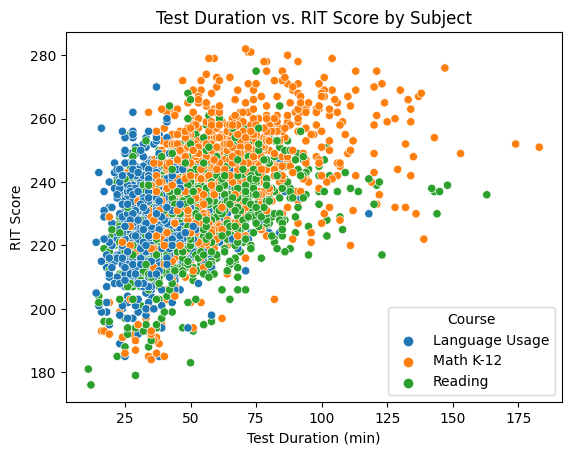

In [16]:
sns.scatterplot(data=new_alldata, x="TestDurationMinutes", y="TestRITScore", hue="Course")
plt.title('Test Duration vs. RIT Score by Subject')
plt.xlabel('Test Duration (min)')
plt.ylabel('RIT Score')
plt.show()

A scatterplot of Test Duration vs RIT score shows that there tends to be an upward trend in RIT score based upon how long it took to complete the test.

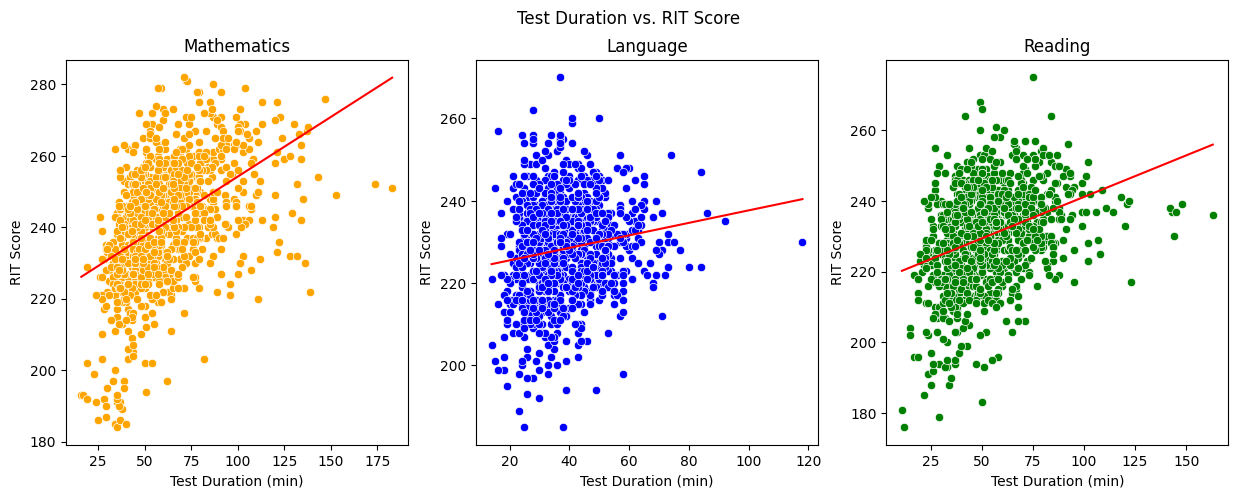

Slope for Mathematics: 0.3337822533437367
Slope for Language: 0.1517633928949449
Slope for Reading: 0.23482964417752378


In [17]:
fig, axs = plt.subplots(ncols=3, figsize=(15,5))

sns.scatterplot(data=math, x="TestDurationMinutes", y="TestRITScore", ax=axs[0], color='orange')
axs[0].set_title('Mathematics')
axs[0].set_xlabel('Test Duration (min)')
axs[0].set_ylabel('RIT Score')

slope_math, intercept_math, _, _, _ = linregress(math["TestDurationMinutes"], math["TestRITScore"])
x_math = np.array([math["TestDurationMinutes"].min(), math["TestDurationMinutes"].max()])
y_math = slope_math * x_math + intercept_math
axs[0].plot(x_math, y_math, color='red')

sns.scatterplot(data=lang, x="TestDurationMinutes", y="TestRITScore", ax=axs[1], color='b')
axs[1].set_title('Language')
axs[1].set_xlabel('Test Duration (min)')
axs[1].set_ylabel('RIT Score')

slope_lang, intercept_lang, _, _, _ = linregress(lang["TestDurationMinutes"], lang["TestRITScore"])
x_lang = np.array([lang["TestDurationMinutes"].min(), lang["TestDurationMinutes"].max()])
y_lang = slope_lang * x_lang + intercept_lang
axs[1].plot(x_lang, y_lang, color='red')

sns.scatterplot(data=read, x="TestDurationMinutes", y="TestRITScore", ax=axs[2], color='g')
axs[2].set_title('Reading')
axs[2].set_xlabel('Test Duration (min)')
axs[2].set_ylabel('RIT Score')

slope_read, intercept_read, _, _, _ = linregress(read["TestDurationMinutes"], read["TestRITScore"])
x_read = np.array([read["TestDurationMinutes"].min(), read["TestDurationMinutes"].max()])
y_read = slope_read * x_read + intercept_read
axs[2].plot(x_read, y_read, color='red')

plt.suptitle('Test Duration vs. RIT Score')
plt.show()

print("Slope for Mathematics:", slope_math)
print("Slope for Language:", slope_lang)
print("Slope for Reading:", slope_read)

Looking at each test individaully still shows that an increase in testing duration also tends to increase the RIT score.  This trend looks strongest in Mathematics and least strong in Language.

In [18]:
--Average time to take test per term
SELECT m.TermName, ROUND(AVG(m.TestDurationMinutes),2) AS "Math AVG Time",
	ROUND(AVG(r.TestDurationMinutes),2) AS "Reading AVG Time",
	ROUND(AVG(l.TestDurationMinutes),2) AS "Lang AVG Time"
FROM 'Math.csv' as m
INNER JOIN 'Reading.csv' as r
ON m.TermName = r.TermName
INNER JOIN 'Language.csv' as l
ON m.TermName = l.TermName
GROUP BY m.TermName;

,TermName,Math AVG Time,Reading AVG Time,Lang AVG Time
0,Fall 2019-2020,61.04,57.89,41.12
1,Winter 2019-2020,59.08,49.48,38.01
2,Fall 2020-2021,64.03,53.29,44.64
3,Winter 2020-2021,63.25,54.39,38.62
4,Fall 2021-2022,69.37,53.04,44.75
5,Winter 2021-2022,65.90,50.61,39.58
6,Spring 2021-2022,69.15,49.04,37.47
7,Fall 2022-2023,57.27,57.57,33.80
8,Winter 2022-2023,55.43,56.20,34.55
9,Spring 2022-2023,55.74,55.66,33.03


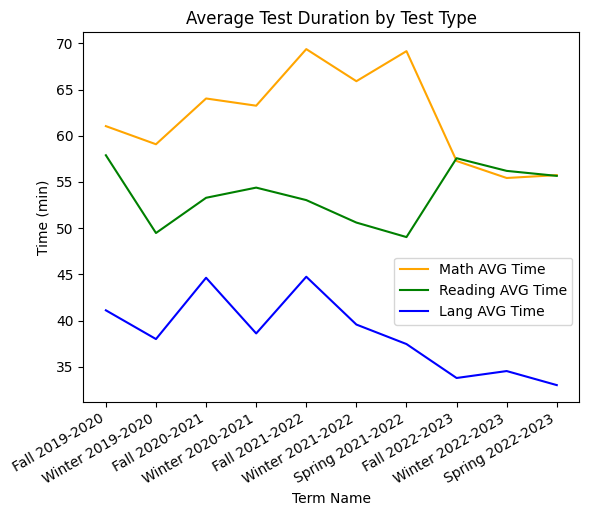

In [19]:
df3.plot(x='TermName', color={'Math AVG Time': 'orange', 'Reading AVG Time': 'green', 'Lang AVG Time': 'blue'})
plt.title('Average Test Duration by Test Type')
plt.xlabel('Term Name')
plt.ylabel('Time (min)')
plt.xticks(range(len(df3)), df3['TermName'], rotation=30, ha='right')
plt.legend(loc='lower center')
plt.legend(loc='center right', bbox_to_anchor=(1, 0.3))
plt.show()

The average test duration data shows that the last year of testing had a distinct change in testing time--decrease for Math and Language and an increase for Reading. 

The correlation for test duration and RIT scores was moderate (0.45).  To see if the decrease in testing time impacted the RIT scores, I will exclude the last year of data and redo the correlation to compare differences.

In [20]:
# Calculate the correlation between TestDuration and TestRITScore for each course all years
correlation_course = new_alldata.groupby('Course')[['TestDurationMinutes', 'TestRITScore']].corr()

print("Correlation for each course all years")
correlation_course

Correlation for each course all years


TestDurationMinutes  TestRITScore
Course                                                               
Language Usage TestDurationMinutes             1.000000      0.155322
               TestRITScore                    0.155322      1.000000
Math K-12      TestDurationMinutes             1.000000      0.466469
               TestRITScore                    0.466469      1.000000
Reading        TestDurationMinutes             1.000000      0.347898
               TestRITScore                    0.347898      1.000000

In [21]:
#Correlation between TestDurationa nd 
threeyears = new_alldata[new_alldata['Year']!= '2022-2023']
correl_threeyears = threeyears.groupby('Course')[['TestDurationMinutes', 'TestRITScore']].corr()

print("Correlation for each course first three years")
correl_threeyears

Correlation for each course first three years


TestDurationMinutes  TestRITScore
Course                                                               
Language Usage TestDurationMinutes             1.000000      0.190168
               TestRITScore                    0.190168      1.000000
Math K-12      TestDurationMinutes             1.000000      0.461384
               TestRITScore                    0.461384      1.000000
Reading        TestDurationMinutes             1.000000      0.358076
               TestRITScore                    0.358076      1.000000

The correlation values do not change very much, making it unlikely that the change in testing durations has affected RIT scores.

## Percent Correct

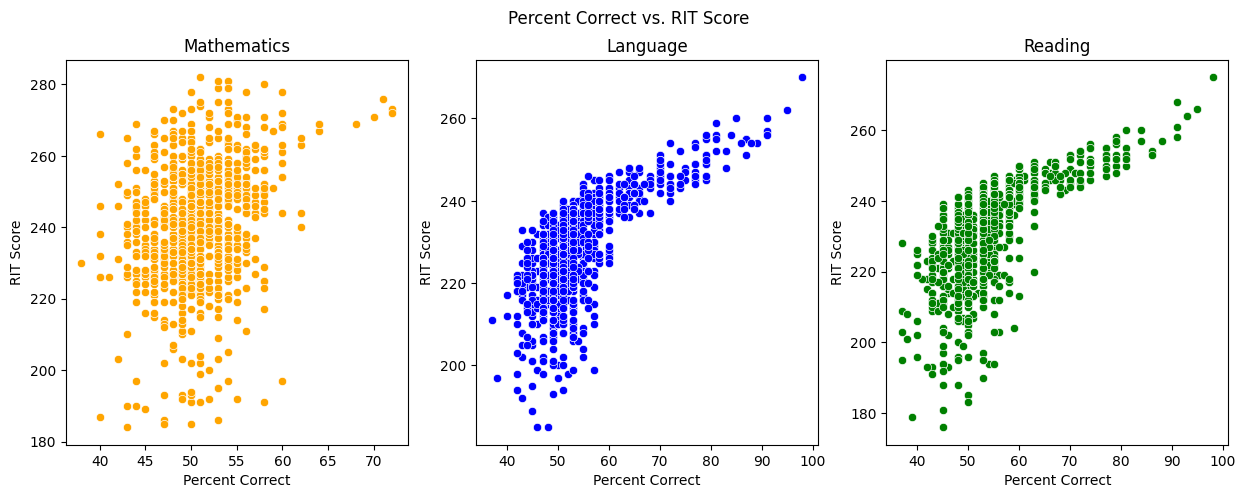

In [22]:
fig, axs = plt.subplots(ncols=3, figsize=(15,5))

sns.scatterplot(data=math, x="PercentCorrect", y="TestRITScore", ax=axs[0], color='orange')
axs[0].set_title('Mathematics')
axs[0].set_xlabel('Percent Correct')
axs[0].set_ylabel('RIT Score')

sns.scatterplot(data=lang, x="PercentCorrect", y="TestRITScore", ax=axs[1], color='b')
axs[1].set_title('Language')
axs[1].set_xlabel('Percent Correct')
axs[1].set_ylabel('RIT Score')

sns.scatterplot(data=read, x="PercentCorrect", y="TestRITScore", ax=axs[2], color='g')
axs[2].set_title('Reading')
axs[2].set_xlabel('Percent Correct')
axs[2].set_ylabel('RIT Score')

plt.suptitle('Percent Correct vs. RIT Score')
plt.show()

Analyzing the scatterplots depicting RIT Scores versus Percent Correct, it is evident that the data for the Mathematics test exhibits a greater dispersion, aligning with the previously observed weak correlation (0.27). Conversely, the scatterplots for Language and Reading demonstrate a more concentrated distribution and a strong correlation (0.71 and 0.67 respectively).

These findings suggest that in the Mathematics test, it is possible to achieve higher RIT Scores despite lower percentages, indicating a wider range of question difficulty levels. In contrast, for Language and Reading, attaining high RIT Scores necessitates a higher percentage of correct answers.

## Test Percentile
Test percentile referrs to how the student compared to other students.

A score in the 50th percentile is considered “average” – meaning it is right in the middle of where students in that specific grade score during that time of the year. A score in the 95th percentile means that is it better than 95% of other students in that grade level during that time of the year.

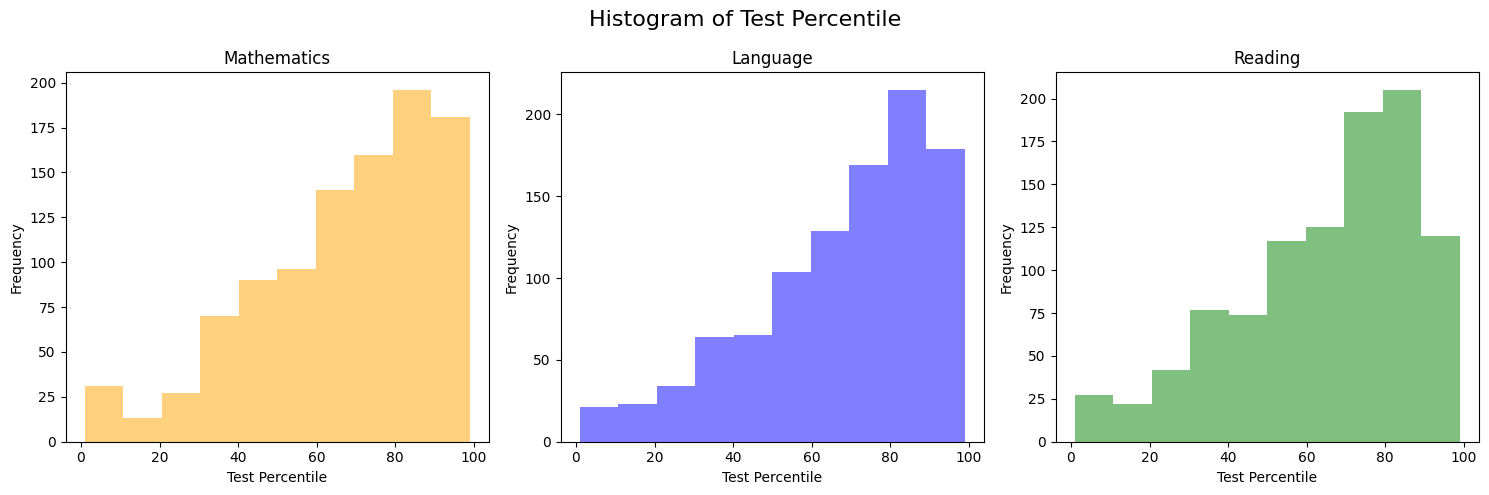

In [23]:
import matplotlib.pyplot as plt

# Filter the dataframe to include only the necessary columns
course1_percentile = new_alldata[new_alldata['Course'] == 'Math K-12']['TestPercentile']
course2_percentile = new_alldata[new_alldata['Course'] == 'Language Usage']['TestPercentile']
course3_percentile = new_alldata[new_alldata['Course'] == 'Reading']['TestPercentile']

# Create a subplot with three histograms
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot histogram for Course 1
axs[0].hist(course1_percentile, bins=10, alpha=0.5, color = 'orange')
axs[0].set_xlabel('Test Percentile')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Mathematics')

# Plot histogram for Course 2
axs[1].hist(course2_percentile, bins=10, alpha=0.5, color = 'blue')
axs[1].set_xlabel('Test Percentile')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Language')

# Plot histogram for Course 3
axs[2].hist(course3_percentile, bins=10, alpha=0.5, color = 'green')
axs[2].set_xlabel('Test Percentile')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Reading')

# Adjust spacing between subplots
plt.suptitle('Histogram of Test Percentile', fontsize = 16)
plt.tight_layout()

# Show the plot
plt.show()

The histograms exhibit a left-skewed distribution, indicating that a majority of the data falls towards higher percentiles. It is noteworthy that a significant proportion of students perform above the 50th percentile. However, it is crucial to pay attention to students who score below the 50th percentile and provide appropriate support and interventions for their academic progress.

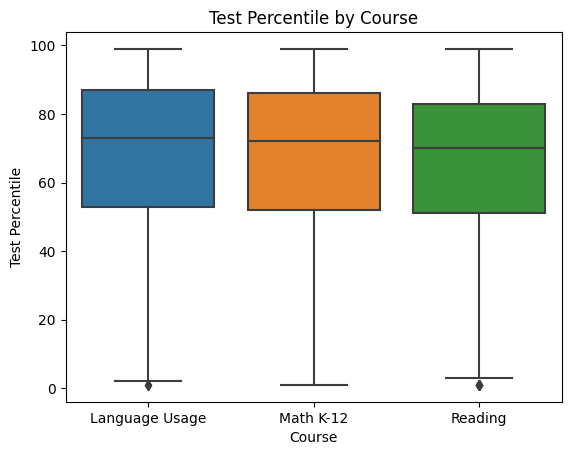

In [24]:
sns.boxplot(data=new_alldata, x="Course", y="TestPercentile")
plt.title('Test Percentile by Course')
plt.xlabel('Course')
plt.ylabel('Test Percentile')

plt.show()

The boxplot illustrates that the median score for all three tests is approximately 70%, indicating a relatively high level of performance among our students. Furthermore, it reveals that 75% of the students achieved a percentile rank of 50 or above, reinforcing the findings observed in the histogram analysis.

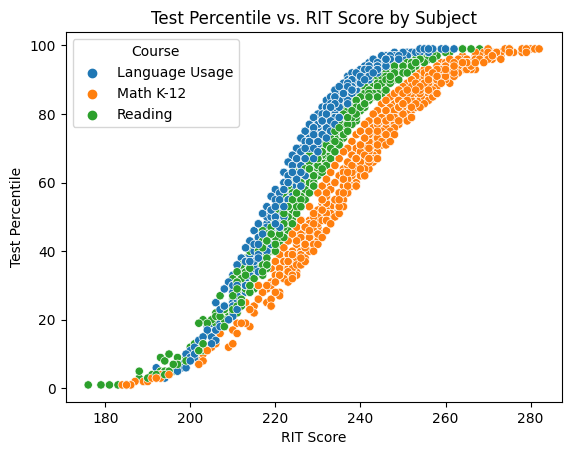

In [25]:
sns.scatterplot(data=new_alldata,y="TestPercentile", x="TestRITScore", hue="Course")
plt.title('Test Percentile vs. RIT Score by Subject')
plt.ylabel('Test Percentile')
plt.xlabel('RIT Score')
plt.show()

The scatterplot demonstrates a significant positive correlation between the Test Percentile and the corresponding RIT score attained by students. This finding further supports the earlier analysis, which revealed a very strong correlation coefficient of 0.97 between these variables.

## Achievement Quintile

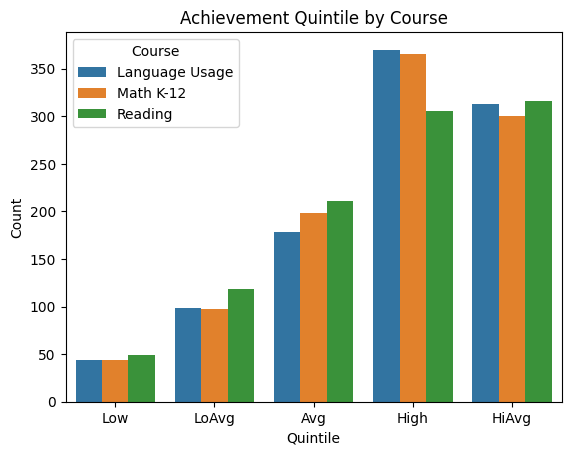

In [26]:
sns.countplot(data=new_alldata, x="AchievementQuintile", hue="Course", order=["Low", "LoAvg", "Avg", "High", "HiAvg"])
plt.title('Achievement Quintile by Course')
plt.xlabel('Quintile')
plt.ylabel('Count')
plt.legend(title='Course')
plt.show()

The majority of students have achieved at the High or Hi Average quintile.

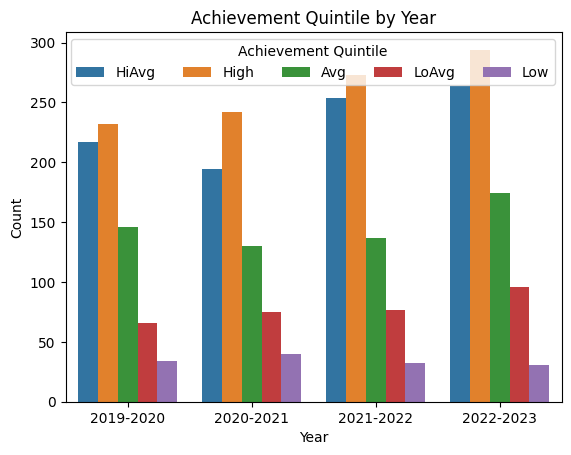

In [27]:
sns.countplot(data=new_alldata, x="Year", hue="AchievementQuintile")
plt.title('Achievement Quintile by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Achievement Quintile', loc='upper right', ncol=5)
plt.show()

The number of students who achieved at the quintile levels of LoAvg, High, and HiAvg (excluding the 2020-2021 academic year) has shown a consistent increase over the years. Conversely, there has been a noticeable decrease in the number of students who achieved the Low quintile.

## Breakdown by Class

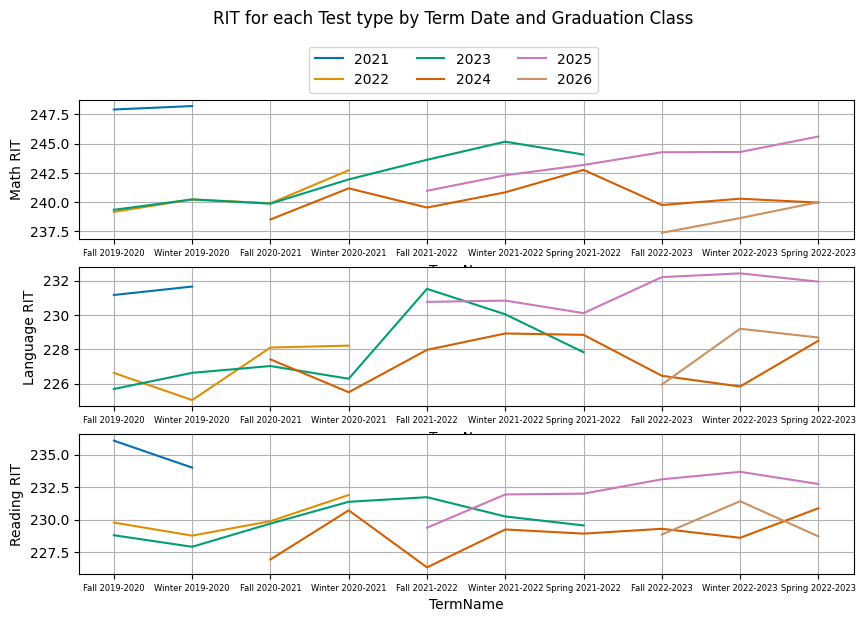

In [28]:
fig, axs = plt.subplots(3, 1, figsize=(10, 6))

sns.lineplot(data=new_alldata[new_alldata['Subject']=='Mathematics'], x='TermName', y='TestRITScore', hue='ClassOf', ci=None, ax=axs[0], palette='colorblind')
axs[0].set_ylabel('Math RIT')
axs[0].tick_params('x', labelsize=6)
axs[0].grid(True)
axs[0].legend().remove()

sns.lineplot(data=new_alldata[new_alldata['Course']=='Language Usage'], x='TermName', y='TestRITScore', hue='ClassOf', ci=None, ax=axs[1], palette='colorblind')
axs[1].set_ylabel('Language RIT')
axs[1].tick_params('x', labelsize=6)
axs[1].grid(True)
axs[1].legend().remove()

sns.lineplot(data=new_alldata[new_alldata['Course']=='Reading'], x='TermName', y='TestRITScore', hue='ClassOf', ci=None, ax=axs[2], palette='colorblind')
axs[2].set_xlabel('TermName')
axs[2].set_ylabel('Reading RIT')
axs[2].tick_params('x', labelsize=6)
axs[2].grid(True)
axs[2].legend().remove()

plt.suptitle('RIT for each Test type by Term Date and Graduation Class', y = 1.05)

# adjust spacing between subplots and top of figure
plt.subplots_adjust(top=0.9)

# put legend above chart
fig.legend(handles=axs[0].get_legend_handles_labels()[0], labels=axs[0].get_legend_handles_labels()[1], loc='upper center', bbox_to_anchor=(0.5, 1), ncol=3)
plt.show()

Based on the analysis, it can be observed that there is a general upward trend in RIT scores across different classes. Notably, the Class of 2023 and 2024, which have been tested for three years, exhibit a decrease in their scores during their final year of testing. This decline may suggest a potential lack of engagement or interest in the testing process. Conversely, the Class of 2025 demonstrates higher RIT scores compared to other classes. Monitoring their performance in the upcoming final year of testing will be crucial to determine if they follow the pattern of previous classes and experience a decline in scores. These findings highlight the importance of assessing and addressing factors that may impact students' motivation and performance in standardized testing.

## Math Data

In [29]:
#Math score seperated by Season
fall_math_scores=math[math['Season']=='Fall']
winter_math_scores=math[math['Season']=='Winter']
spring_math_scores=math[math['Season']=='Spring']

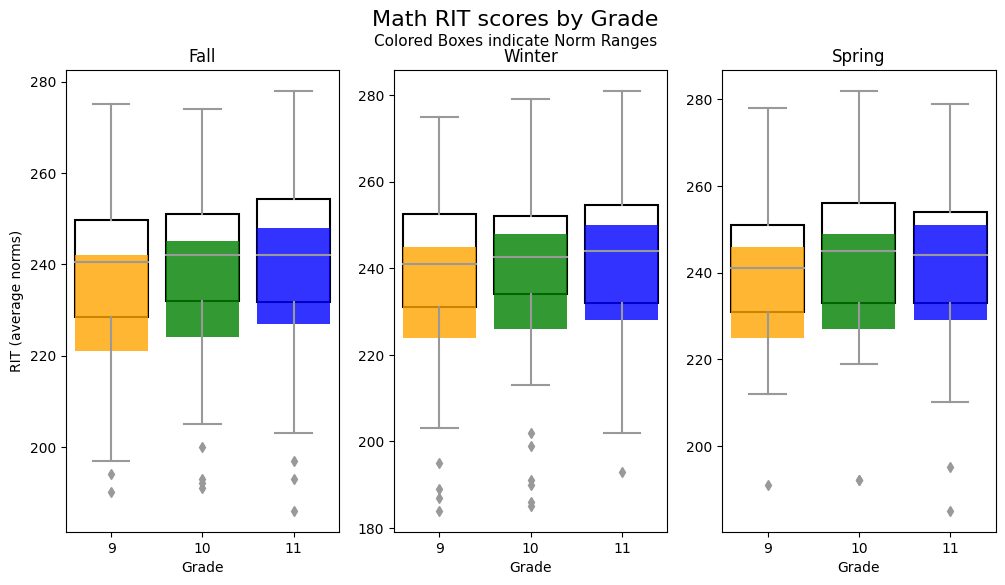

In [30]:
fig, (ax3, ax4, ax5) = plt.subplots(1, 3, figsize=(12, 6))

sns.boxplot(data=fall_math_scores, x='Grade', y='TestRITScore', color='white', boxprops=dict(edgecolor='k'), ax=ax3)
ax3.set_title('Fall')
ax3.set_ylabel('RIT (average norms)')

sns.boxplot(data=winter_math_scores, x='Grade', y='TestRITScore', color='white', boxprops=dict(edgecolor='k'), ax=ax4)
ax4.set_title('Winter')
ax4.set_ylabel('')

sns.boxplot(data=spring_math_scores, x='Grade', y='TestRITScore', color='white', boxprops=dict(edgecolor='k'), ax=ax5)
ax5.set_title('Spring')
ax5.set_ylabel('')
fig.suptitle('Math RIT scores by Grade', fontsize=16)
fig.text(0.5, 0.92, 'Colored Boxes indicate Norm Ranges', fontsize=11, ha='center')

m_nine_fall = patches.Rectangle((-0.4, 221), 0.8, 21, facecolor = 'orange', alpha =0.8)
m_ten_fall = patches.Rectangle((0.6, 224), 0.8, 21, facecolor = 'green', alpha =0.8)
m_eleven_fall = patches.Rectangle((1.6, 227), 0.8, 21, facecolor= 'blue', alpha =0.8)
ax3.add_patch(m_nine_fall)
ax3.add_patch(m_ten_fall)
ax3.add_patch(m_eleven_fall)

m_nine_winter = patches.Rectangle((-0.4, 224), 0.8, 21, facecolor = 'orange', alpha =0.8)
m_ten_winter = patches.Rectangle((0.6, 226), 0.8, 22, facecolor = 'green', alpha =0.8)
m_eleven_winter = patches.Rectangle((1.6, 228), 0.8, 22, facecolor= 'blue', alpha =0.8)
ax4.add_patch(m_nine_winter)
ax4.add_patch(m_ten_winter)
ax4.add_patch(m_eleven_winter)

m_nine_spring = patches.Rectangle((-0.4, 225), 0.8, 21, facecolor = 'orange', alpha =0.8)
m_ten_spring = patches.Rectangle((0.6, 227), 0.8, 22, facecolor = 'green', alpha =0.8)
m_eleven_spring = patches.Rectangle((1.6, 229), 0.8, 22, facecolor= 'blue', alpha =0.8)
ax5.add_patch(m_nine_spring)
ax5.add_patch(m_ten_spring)
ax5.add_patch(m_eleven_spring)

plt.show()

The breakdown of norms by grade and season show that for each instance, 75% or more of our students are in or above the normal range.

In [31]:
math_short=math[['TermName','StudentID', 'Goal1Name','Goal1RitScore', 'Goal1Adjective', 'Goal2Name','Goal2RitScore', 'Goal2Adjective','Goal3Name','Goal3RitScore', 'Goal3Adjective','Goal4Name','Goal4RitScore', 'Goal4Adjective','Goal5Name','Goal5RitScore', 'Goal5Adjective']]
#Change Goal1 & Goal2 Names so they will fit in Graph without overlapping
math_short['Goal1Name'] = 'Operations & Algebraic Thinking'
math_short['Goal2Name'] = 'Real & Complex Number Systems'

Text(0.5, 0.98, 'RIT Scores for Math Goals')

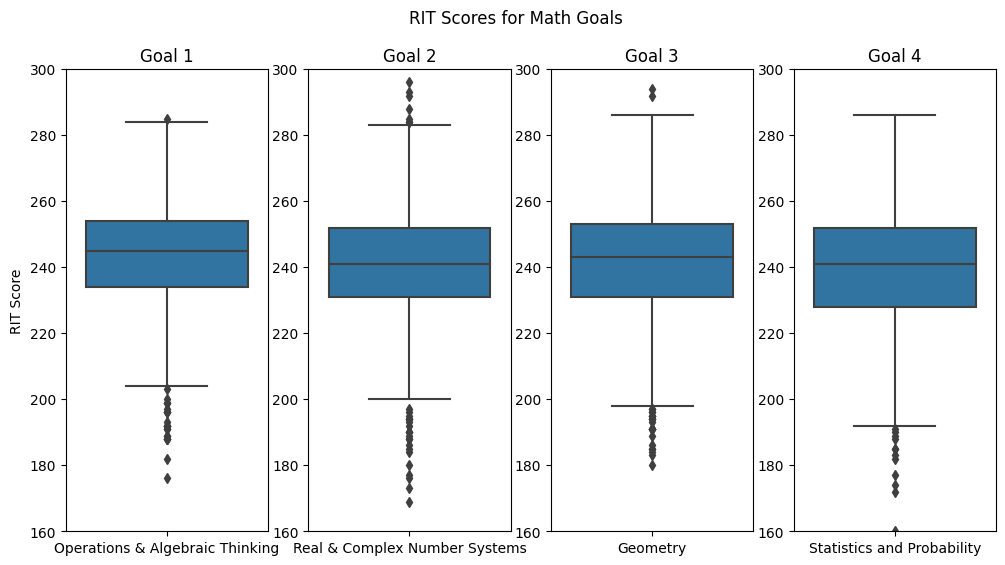

In [32]:
fig, (ax2, ax3, ax4, ax5) = plt.subplots(1, 4, figsize=(12, 6))
for ax in [ax2, ax3, ax4, ax5]:
    ax.set_ylim(160, 300)
sns.boxplot(data=math_short, x='Goal1Name', y='Goal1RitScore', ax=ax2)
sns.boxplot(data=math_short, x='Goal2Name', y='Goal2RitScore', ax=ax3)
sns.boxplot(data=math_short, x='Goal3Name', y='Goal3RitScore', ax=ax4)
sns.boxplot(data=math_short, x='Goal4Name', y='Goal4RitScore', ax=ax5)
ax2.set_ylabel('RIT Score')
ax2.set_title('Goal 1')
ax2.set_xlabel('')
ax3.set_ylabel('')
ax3.set_title('Goal 2')
ax3.set_xlabel('')
ax4.set_ylabel('')
ax4.set_title('Goal 3')
ax4.set_xlabel('')
ax5.set_ylabel('')
ax5.set_title('Goal 4')
ax5.set_xlabel('')
fig.suptitle('RIT Scores for Math Goals')

Upon analyzing the math goals, the median RIT score for each goal is approximately 240. Notably, the Real & Complex Number System goal exhibits the highest number of outliers, both above and below the normal range. This observation can be attributed to the fact that students typically encounter the Complex Number system in Algebra 2, a subject commonly taught during the 11th grade. Conversely, the Statistics and Probability goal does not display any outliers exceeding the maximum value. This finding aligns with the absence of a dedicated class focusing on these concepts in our school.

In [33]:
correlation_matrix = math[['TestRITScore', 'Goal1RitScore', 'Goal2RitScore', 'Goal3RitScore', 'Goal4RitScore']].corr().round(3)
correlation_matrix

,TestRITScore,Goal1RitScore,Goal2RitScore,Goal3RitScore,Goal4RitScore
TestRITScore,1.000,0.933,0.941,0.934,0.936
Goal1RitScore,0.933,1.000,0.845,0.827,0.826
Goal2RitScore,0.941,0.845,1.000,0.836,0.846
Goal3RitScore,0.934,0.827,0.836,1.000,0.834
Goal4RitScore,0.936,0.826,0.846,0.834,1.000


The correlation matrix reveals a significant and positive correlation between the test RIT Score and each of the test goals. Furthermore, the test goals themselves exhibit a strong correlation with each other, albeit slightly lower than their correlation with the overall test RIT score.

## Language Data

In [34]:
#Language score seperated by Season
fall_lang_scores=lang[lang['Season']=='Fall']
winter_lang_scores=lang[lang['Season']=='Winter']
spring_lang_scores=lang[lang['Season']=='Spring']

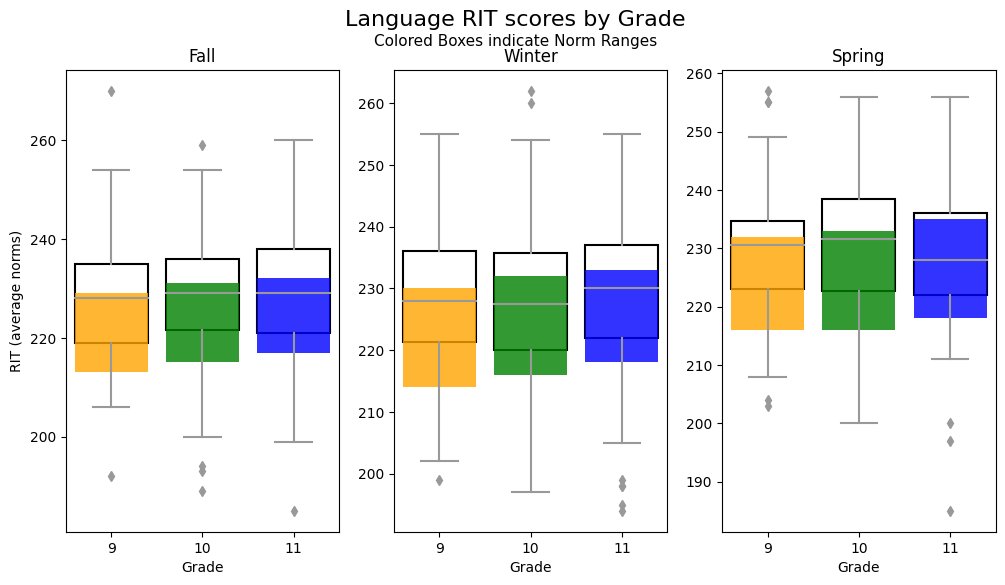

In [35]:
fig, (ax3, ax4, ax5) = plt.subplots(1, 3, figsize=(12, 6))

sns.boxplot(data=fall_lang_scores, x='Grade', y='TestRITScore', color='white', boxprops=dict(edgecolor='k'), ax=ax3)
ax3.set_title('Fall')
ax3.set_ylabel('RIT (average norms)')

sns.boxplot(data=winter_lang_scores, x='Grade', y='TestRITScore', color='white', boxprops=dict(edgecolor='k'), ax=ax4)
ax4.set_title('Winter')
ax4.set_ylabel('')

sns.boxplot(data=spring_lang_scores, x='Grade', y='TestRITScore', color='white', boxprops=dict(edgecolor='k'), ax=ax5)
ax5.set_title('Spring')
ax5.set_ylabel('')
fig.suptitle('Language RIT scores by Grade', fontsize=16)
fig.text(0.5, 0.92, 'Colored Boxes indicate Norm Ranges', fontsize=11, ha='center')

l_nine_fall = patches.Rectangle((-0.4, 213), 0.8, 16, facecolor = 'orange', alpha =0.8)
l_ten_fall = patches.Rectangle((0.6, 215), 0.8, 16, facecolor = 'green', alpha =0.8)
l_eleven_fall = patches.Rectangle((1.6, 217), 0.8, 15, facecolor= 'blue', alpha =0.8)
ax3.add_patch(l_nine_fall)
ax3.add_patch(l_ten_fall)
ax3.add_patch(l_eleven_fall)

l_nine_winter = patches.Rectangle((-0.4, 214), 0.8, 16, facecolor = 'orange', alpha =0.8)
l_ten_winter = patches.Rectangle((0.6, 216), 0.8, 16, facecolor = 'green', alpha =0.8)
l_eleven_winter = patches.Rectangle((1.6, 218), 0.8, 15, facecolor= 'blue', alpha =0.8)
ax4.add_patch(l_nine_winter)
ax4.add_patch(l_ten_winter)
ax4.add_patch(l_eleven_winter)

l_nine_spring = patches.Rectangle((-0.4, 216), 0.8, 16, facecolor = 'orange', alpha =0.8)
l_ten_spring = patches.Rectangle((0.6, 216), 0.8, 17, facecolor = 'green', alpha =0.8)
l_eleven_spring = patches.Rectangle((1.6, 218), 0.8, 17, facecolor= 'blue', alpha =0.8)
ax5.add_patch(l_nine_spring)
ax5.add_patch(l_ten_spring)
ax5.add_patch(l_eleven_spring)

plt.show()

The breakdown of norms by grade and season show that for each instance, 75% or more of our students are in or above the normal range.

In [36]:
lang_short=lang[['TermName','StudentID', 'Goal1Name','Goal1RitScore', 'Goal2Name','Goal2RitScore', 'Goal3Name','Goal3RitScore', 'Goal4Name','Goal4RitScore', 'Goal5Name','Goal5RitScore']]

#Change Goal1 & Goal2 Names so they will fit in Graph without overlapping
lang_short['Goal1Name'] = 'Write, Revise Text for Purpose & Audience'
lang_short['Goal2Name'] = 'Understand, Edit for Grammar, Usage'
lang_short['Goal3Name'] = 'Understand, Edit for Mechanics'

Text(0.5, 0.98, 'RIT Scores for Language Goals')

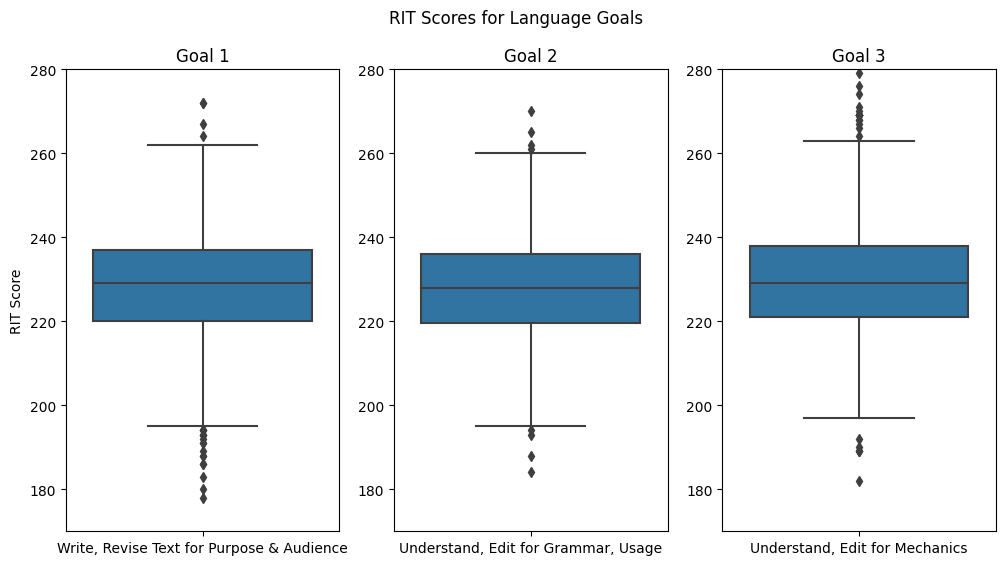

In [37]:
fig, (ax2, ax3, ax4) = plt.subplots(1, 3, figsize=(12, 6))
for ax in [ax2, ax3, ax4]:
    ax.set_ylim(170, 280)
sns.boxplot(data=lang_short, x='Goal1Name', y='Goal1RitScore', ax=ax2)
sns.boxplot(data=lang_short, x='Goal2Name', y='Goal2RitScore', ax=ax3)
sns.boxplot(data=lang_short, x='Goal3Name', y='Goal3RitScore', ax=ax4)
ax2.set_ylabel('RIT Score')
ax2.set_title('Goal 1')
ax2.set_xlabel('')
ax3.set_ylabel('')
ax3.set_title('Goal 2')
ax3.set_xlabel('')
ax4.set_ylabel('')
ax4.set_title('Goal 3')
ax4.set_xlabel('')
fig.suptitle('RIT Scores for Language Goals')

Looking at the language goals shows that the median RIT score is close to 230 for each goal.  Based upon number and direction of the outliers, Understand and Edit for Mechanics is a strength of our program while Write, Reviese Text for Purpose & Audience could use more focus.

In [38]:
correlation_matrix = lang[['TestRITScore', 'Goal1RitScore', 'Goal2RitScore', 'Goal3RitScore']].corr().round(3)
correlation_matrix

,TestRITScore,Goal1RitScore,Goal2RitScore,Goal3RitScore
TestRITScore,1.000,0.917,0.918,0.892
Goal1RitScore,0.917,1.000,0.774,0.715
Goal2RitScore,0.918,0.774,1.000,0.745
Goal3RitScore,0.892,0.715,0.745,1.000


The correlation matrix reveals a significant and positive correlation between the test RIT Score and each of the test goals. Furthermore, the test goals themselves exhibit a strong correlation with each other, albeit slightly lower than their correlation with the overall test RIT score.

## Reading Data

In [39]:
#Reading score seperated by Season
fall_read_scores=read[read['Season']=='Fall']
winter_read_scores=read[read['Season']=='Winter']
spring_read_scores=read[read['Season']=='Spring']

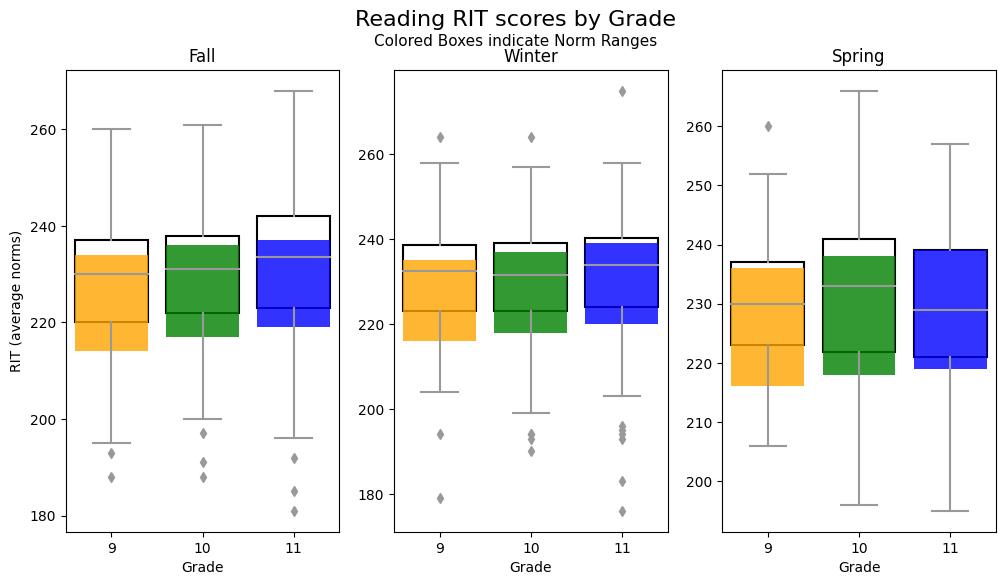

In [40]:
fig, (ax3, ax4, ax5) = plt.subplots(1, 3, figsize=(12, 6))

sns.boxplot(data=fall_read_scores, x='Grade', y='TestRITScore', color='white', boxprops=dict(edgecolor='k'), ax=ax3)
ax3.set_title('Fall')
ax3.set_ylabel('RIT (average norms)')

sns.boxplot(data=winter_read_scores, x='Grade', y='TestRITScore', color='white', boxprops=dict(edgecolor='k'), ax=ax4)
ax4.set_title('Winter')
ax4.set_ylabel('')

sns.boxplot(data=spring_read_scores, x='Grade', y='TestRITScore', color='white', boxprops=dict(edgecolor='k'), ax=ax5)
ax5.set_title('Spring')
ax5.set_ylabel('')
fig.suptitle('Reading RIT scores by Grade', fontsize=16)
fig.text(0.5, 0.92, 'Colored Boxes indicate Norm Ranges', fontsize=11, ha='center')

r_nine_fall = patches.Rectangle((-0.4, 214), 0.8, 20, facecolor = 'orange', alpha =0.8)
r_ten_fall = patches.Rectangle((0.6, 217), 0.8, 19, facecolor = 'green', alpha =0.8)
r_eleven_fall = patches.Rectangle((1.6, 219), 0.8, 18, facecolor= 'blue', alpha =0.8)
ax3.add_patch(r_nine_fall)
ax3.add_patch(r_ten_fall)
ax3.add_patch(r_eleven_fall)

r_nine_winter = patches.Rectangle((-0.4, 216), 0.8, 19, facecolor = 'orange', alpha =0.8)
r_ten_winter = patches.Rectangle((0.6, 218), 0.8, 19, facecolor = 'green', alpha =0.8)
r_eleven_winter = patches.Rectangle((1.6, 220), 0.8, 19, facecolor= 'blue', alpha =0.8)
ax4.add_patch(r_nine_winter)
ax4.add_patch(r_ten_winter)
ax4.add_patch(r_eleven_winter)

r_nine_spring = patches.Rectangle((-0.4, 216), 0.8, 20, facecolor = 'orange', alpha =0.8)
r_ten_spring = patches.Rectangle((0.6, 218), 0.8, 20, facecolor = 'green', alpha =0.8)
r_eleven_spring = patches.Rectangle((1.6, 219), 0.8, 20, facecolor= 'blue', alpha =0.8)
ax5.add_patch(r_nine_spring)
ax5.add_patch(r_ten_spring)
ax5.add_patch(r_eleven_spring)

plt.show()

plt.show()

The breakdown of norms by grade and season show that for each instance, 75% or more of our students are in or above the normal range.

In [41]:
read_short=read[['TestName', 'TermName','StudentID', 'TestRITScore', 'Goal1Name','Goal1RitScore', 'Goal2Name','Goal2RitScore', 'Goal3Name','Goal3RitScore', 'Goal4Name','Goal4RitScore', 'Goal5Name','Goal5RitScore']]

Since MAPS updated the goal names I need to change the goal names in the old test to the same names used for the new test.  This will require me to split the data into two sections based upon the tests.  For the old test I averaged the RIT scores that deal with Literary Text together and the scores that deal with Information Text together so that they would look the same as the new test catergories.  Then I put the dataframes back together.

In [42]:
#Newer test data
read_short_new = read_short[read_short['TestName']=='Growth: Reading 6+ OR 2019']
read_short_new=read_short_new[['TestName', 'TermName','StudentID', 'TestRITScore', 'Goal1Name','Goal1RitScore', 'Goal2Name','Goal2RitScore', 'Goal3Name','Goal3RitScore']]

#Older test data
read_short_old = read_short[read_short['TestName']=='Growth: Reading 6+ CCSS 2010 V3']
read_short_old['Goal1_Name'] = 'Literary Text'
read_short_old['Goal1_RitScore']= (read_short_old['Goal1RitScore'] + read_short_old['Goal2RitScore'])/2
read_short_old['Goal2_Name'] = 'Informational Text'
read_short_old['Goal2_RitScore']= (read_short_old['Goal3RitScore'] + read_short_old['Goal4RitScore'])/2
read_short_old['Goal3_Name'] = 'Vocabulary'
read_short_old['Goal3_RitScore']= read_short_old['Goal5RitScore']
read_short_old=read_short_old[['TestName', 'TermName','StudentID', 'TestRITScore', 'Goal1_Name','Goal1_RitScore', 'Goal2_Name','Goal2_RitScore', 'Goal3_Name','Goal3_RitScore']]
read_short_old.rename(columns={'Goal1_Name': 'Goal1Name', 'Goal1_RitScore': 'Goal1RitScore', 'Goal2_Name': 'Goal2Name', 'Goal2_RitScore': 'Goal2RitScore','Goal3_Name': 'Goal3Name', 'Goal3_RitScore': 'Goal3RitScore'}, inplace=True)

#Combining data back together
read_short_updated = pd.concat([read_short_old, read_short_new])

Text(0.5, 0.98, 'RIT Scores for Reading Goals')

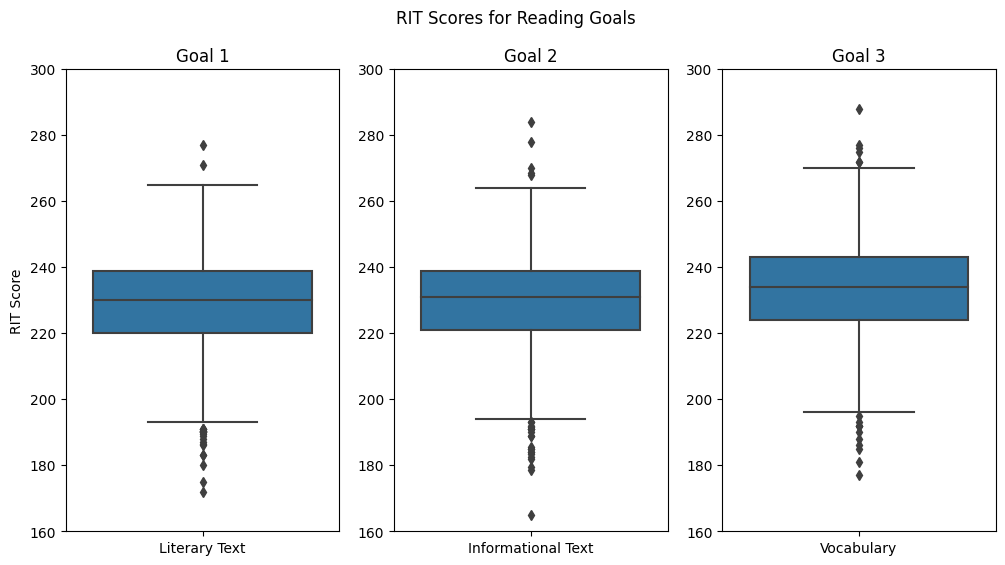

In [43]:
fig, (ax2, ax3, ax4) = plt.subplots(1, 3, figsize=(12, 6))
for ax in [ax2, ax3, ax4]:
    ax.set_ylim(160, 300)
sns.boxplot(data=read_short_updated, x='Goal1Name', y='Goal1RitScore', ax=ax2)
sns.boxplot(data=read_short_updated, x='Goal2Name', y='Goal2RitScore', ax=ax3)
sns.boxplot(data=read_short_updated, x='Goal3Name', y='Goal3RitScore', ax=ax4)
ax2.set_ylabel('RIT Score')
ax2.set_title('Goal 1')
ax2.set_xlabel('')
ax3.set_ylabel('')
ax3.set_title('Goal 2')
ax3.set_xlabel('')
ax4.set_ylabel('')
ax4.set_title('Goal 3')
ax4.set_xlabel('')
fig.suptitle('RIT Scores for Reading Goals')

Looking at the reading goals shows that the median RIT score is close to 230 for each goal.  Based upon number and direction of the outliers, all three goals could use support.

In [44]:
correlation_matrix = read[['TestRITScore', 'Goal1RitScore', 'Goal2RitScore', 'Goal3RitScore']].corr().round(3)
correlation_matrix

,TestRITScore,Goal1RitScore,Goal2RitScore,Goal3RitScore
TestRITScore,1.000,0.913,0.904,0.885
Goal1RitScore,0.913,1.000,0.788,0.739
Goal2RitScore,0.904,0.788,1.000,0.726
Goal3RitScore,0.885,0.739,0.726,1.000


The correlation matrix reveals a significant and positive correlation between the test RIT Score and each of the test goals. Furthermore, the test goals themselves exhibit a strong correlation with each other, albeit slightly lower than their correlation with the overall test RIT score.

The reading test also provides a Lexile Score, which is a measure of a student's reading comprehension. This score helps students and teachers match texts to a student's comprehension level. For more information about Lexile Scores and a chart illustrating Lexile levels and corresponding grade levels, please refer to the following link: https://lexile.com/educators/measuring-growth-with-lexile/college-and-career-readiness/.

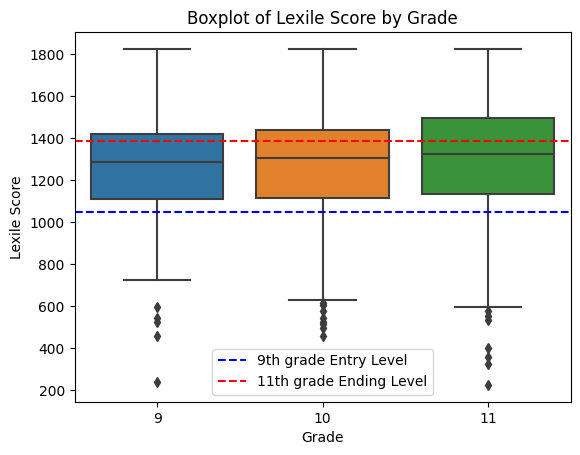

In [64]:
sns.boxplot(data=read, x='Grade', y='LexileScore')
plt.title('Boxplot of Lexile Score by Grade')
plt.xlabel('Grade')
plt.ylabel('Lexile Score')
plt.axhline(y=1050, color='blue', linestyle='--', label='9th grade Entry Level')
plt.axhline(y=1385, color='red', linestyle='--', label='11th grade Ending Level')
plt.legend()
plt.show()

The boxplot illustrates a consistent growth in Lexile Score across grade levels, with a noticeable increase in the median value for each grade. It is worth mentioning that over 75% of students surpass the Lexile Score threshold for 9th grade entry level, while less than 50% of 11th graders achieve the ending Lexile Score. However, it is important to consider that these results encompass all testing sessions, and a more refined analysis focusing solely on Spring testing for 11th graders might yield different outcomes.

Furthermore, it is noteworthy that 11th graders exhibit the widest range of data compared to other grades. The lower quartile of their Lexile Scores is lower than that of any other class, and there appears to be a higher number of outliers in their data distribution.

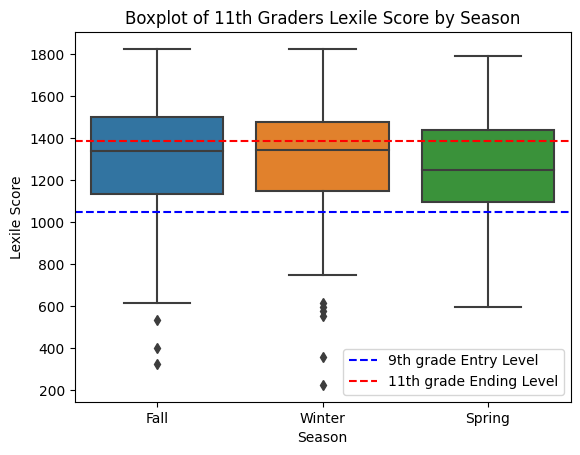

In [68]:
sns.boxplot(data=read[read['Grade']==11], x='Season', y='LexileScore')
plt.title('Boxplot of 11th Graders Lexile Score by Season')
plt.xlabel('Season')
plt.ylabel('Lexile Score')
plt.axhline(y=1050, color='blue', linestyle='--', label='9th grade Entry Level')
plt.axhline(y=1385, color='red', linestyle='--', label='11th grade Ending Level')
plt.legend()
plt.show()

Looking only on the 11th grade data and breaking it apart by testing season, it becomes evident that there is a downward trend in student performance especially in the last testing session.

# Conclusion

Based on the analysis conducted, it is evident that the performance of our students on the MAPS test is commendable. Across all categories, more than 75% of students consistently achieve scores at or above the expected levels. This is indeed a positive outcome.

However, there are a couple of areas that require attention. Firstly, there appears to be a decline in performance among eleventh graders during the testing sessions. This decline could be attributed to various factors, and it is recommended that efforts be made to encourage these students to approach the testing sessions with greater seriousness and dedication. Secondly, it is crucial to focus on the lowest 25% of students who are scoring below the expected levels. It is important to determine whether these students are not taking the testing seriously or if they require additional interventions to support their academic progress.

Addressing these concerns will contribute to further enhancing the overall effectiveness of the testing program and ensuring that all students have the opportunity to reach their full potential.